In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors, PandasTools
from rdkit.ML.Descriptors import MoleculeDescriptors

## A) （準備１）構造式の描き

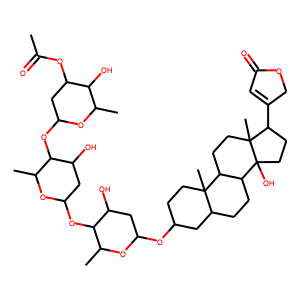

In [2]:
# acetyldigitoxin
mol = Chem.MolFromSmiles("O1C(C)C(OC2OC(C)C(O)C(OC(=O)C)C2)C(O)CC1OC1C(OC(OC2CC3CCC4C(CCC5(C)C(CCC45O)C4=CC(OC4)=O)C3(CC2)C)CC1O)C")
Draw.MolToImage(mol)

## B) （準備２）データ保存

In [3]:
#sm_data = pd.read_excel('SupplementaryTableS1.xlsx',sheet_name='1-SM')
#cpd_data = pd.read_excel('SupplementaryTableS1.xlsx',sheet_name='2-CP')
#sm_df = pd.DataFrame(sm_data,columns=sm_data.columns)
#cpd_df = pd.DataFrame(cpd_data,columns=cpd_data.columns)

#sm_df.to_csv('sm.csv',index=False)
#cpd_df.to_csv('cpd.csv',index=False)

## C) （準備３）記述子の計算

In [4]:
descriptors_list = [item[0] for item in Descriptors.descList]
mol_descriptors_calc = MoleculeDescriptors.MolecularDescriptorCalculator(descriptors_list)

## D) （準備４）lnKa, fb, RMSE, R値の計算

In [5]:
def calc_lnka(fb):
    fb = fb*0.99 + 0.005
    C = 0.3
    lnka = C*np.log(fb/(1-fb))
    return lnka

def calc_fb(lnka):
    C = 0.3
    e_lnka = np.exp(lnka/C)
    fb = e_lnka/(1+e_lnka)
    return fb

def fb_rmse_loss(y_exp,y_pred):
    fb_exp = calc_fb(y_exp)
    fb_pred = calc_fb(y_pred)
    rmse = np.sqrt(np.sum((y_exp-y_pred)**2)/len(y_exp))
    return rmse

def lnka_R_value(y_exp,y_pred):
    dif_exp = y_exp - np.mean(y_exp)
    dif_pred = y_pred - np.mean(y_pred)
    R1 = np.sum(dif_exp*dif_pred)
    R2 = np.sqrt(np.sum(dif_exp**2)*np.sum(dif_pred**2))
    R = R1/R2
    return R

## E) Small molecule データを用いたLasso回帰モデルの構築・選択

In [6]:
sm_data = pd.read_csv('sm.csv')
sm_df = pd.DataFrame(sm_data,columns=sm_data.columns)

sm_SMILES = sm_df["SMILES"].values

sm_desc_data = []
for idx,m in enumerate(sm_SMILES):
    mol = Chem.MolFromSmiles(m)
    mol_desc = mol_descriptors_calc.CalcDescriptors(mol)
    sm_desc_data.append(mol_desc)

In [7]:
from sklearn.preprocessing import StandardScaler
sm_std = StandardScaler()
X_sm_ori = np.array(sm_desc_data)
print(np.max(X_sm_ori))
X_sm = sm_std.fit_transform(X_sm_ori)
y_sm = calc_lnka(np.array(sm_df["PPB (fb)"].values))

1.0676306278191983e+26


In [8]:
#pd.DataFrame(X_sm_ori).to_csv("sm_features.csv")

In [9]:
from sklearn.linear_model import Lasso
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline

Small molecule data
Best fb_rmse: 0.4930988532847925
Best lnKa_R : 0.7159893721146791
Best alpha. : {'alpha': 0.006892612104349695}


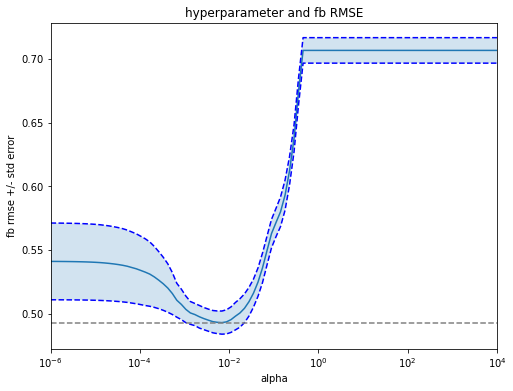

In [10]:
lasso = Lasso(random_state=0, max_iter=1000)

alphas = np.logspace(-6, 4, 100)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

scorer = {'fb_rmse':make_scorer(fb_rmse_loss,greater_is_better=False),
          'lnka_r':make_scorer(lnka_R_value)}

clf = GridSearchCV(lasso, tuned_parameters,scoring=scorer, cv=n_folds, refit='fb_rmse')
clf.fit(X_sm, y_sm)

scores = -clf.cv_results_['mean_test_fb_rmse']
scores_std = clf.cv_results_['std_test_fb_rmse']
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('fb rmse +/- std error')
plt.xlabel('alpha')
plt.axhline(np.min(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])
plt.title('hyperparameter and fb RMSE')

print('Small molecule data')
#print('fb_rmse: ',-clf.cv_results_['mean_test_fb_rmse'])
#print('lnka_R : ',clf.cv_results_['mean_test_lnka_r'])
print('Best fb_rmse:',-clf.cv_results_['mean_test_fb_rmse'][clf.best_index_])
print('Best lnKa_R :',clf.cv_results_['mean_test_lnka_r'][clf.best_index_])
print('Best alpha. :',clf.best_params_)

plt.show()

## F) Cyclic peptide drug の予測と結果

In [11]:
cp_data = pd.read_csv('cpd.csv')
cp_df = pd.DataFrame(cp_data,columns=cp_data.columns)

cp_SMILES = cp_df["SMILES"].values

cp_desc_data = []
for idx,m in enumerate(cp_SMILES):
    mol = Chem.MolFromSmiles(m)
    mol_desc = mol_descriptors_calc.CalcDescriptors(mol)
    cp_desc_data.append(mol_desc)

In [12]:
cp_std = StandardScaler()
X_cp = np.array(cp_desc_data)
X_cp = cp_std.fit_transform(X_cp)
y_cp = calc_lnka(np.array(cp_df["PPB(fb)"].values))

In [13]:
y_cp_pred = clf.best_estimator_.predict(X_cp)

In [14]:
print('Cyclic peptide drug')
print('fb RMSE :', fb_rmse_loss(y_cp,y_cp_pred))
print('lnKa R. :', lnka_R_value(y_cp,y_cp_pred))

Cyclic peptide drug
fb RMSE : 0.627092733705318
lnKa R. : 0.4237004575112741


## G) 比較と考察

E)で得られたcross validation中の予測精度とF)で得られた新しいデータに対する予測精度を比較した結果、F)でのcyclic peptide drugの予測精度の方が低かった。それは学習データにはsmall moleculeのデータのみ利用したからである。学習したモデルにはsmall moleculeの特徴ベクトルが予測によく説明できており、small moleculeのデータに偏ってしまう。一方、新しいデータのcyclic peptide drugについて学習データに含まれていないため予測精度が落ちてしまうと考えられる。

## H) 重要な記述子

In [24]:
coef = np.abs(clf.best_estimator_.coef_)
best_coef_idx = np.argsort(coef)
#print('less-great\n',best_coef_idx)
best_coef_idx_rev = np.flip(best_coef_idx)
#print(best_coef_idx_rev)
for i in best_coef_idx_rev[:10]:
    print('{:_<20}'.format(descriptors_list[i])," : ",clf.best_estimator_.coef_[i])

MolLogP_____________  :  0.2686954798413515
FpDensityMorgan1____  :  -0.19521537601763192
HallKierAlpha_______  :  -0.1832147839758791
VSA_EState10________  :  0.10530589319458779
qed_________________  :  0.10101252464974253
SMR_VSA3____________  :  -0.09236022639264023
MinEStateIndex______  :  -0.09125394936191131
fr_quatN____________  :  -0.08562848308563077
FpDensityMorgan3____  :  0.06678173842561269
MaxAbsPartialCharge_  :  0.06043072584037312


# 発展課題

## Ridge

In [16]:
from sklearn.linear_model import Ridge

ridge = Ridge(random_state=0, max_iter=100)

alphas3 = np.logspace(-6, 4, 100)

tuned_parameters = [{'alpha': alphas3}]
n_folds = 5

scorer = {'fb_rmse':make_scorer(fb_rmse_loss,greater_is_better=False),
          'lnka_r':make_scorer(lnka_R_value)}

clf3 = GridSearchCV(ridge, tuned_parameters,scoring=scorer, cv=n_folds, refit='fb_rmse')
clf3.fit(X_sm, y_sm)

y_cp_pred3 = clf3.best_estimator_.predict(X_cp)

print('Cyclic peptide drug')
print('fb RMSE :', fb_rmse_loss(y_cp,y_cp_pred3))
print('lnKa R. :', lnka_R_value(y_cp,y_cp_pred3))

Cyclic peptide drug
fb RMSE : 0.6194836223988998
lnKa R. : 0.424251937271532


In [17]:
clf3.best_params_

{'alpha': 191.79102616724848}

## ElasticNet

In [18]:
from sklearn.linear_model import ElasticNet

elanet = ElasticNet(random_state=0, max_iter=100)

alphas2 = np.logspace(-6, 4, 100)
l1_ratios = np.logspace(-6,4,100)

tuned_parameters = [{'alpha': alphas2,'l1_ratio':l1_ratios}]
n_folds = 5

scorer = {'fb_rmse':make_scorer(fb_rmse_loss,greater_is_better=False),
          'lnka_r':make_scorer(lnka_R_value)}

clf2 = GridSearchCV(elanet, tuned_parameters,scoring=scorer, cv=n_folds, refit='fb_rmse')
clf2.fit(X_sm, y_sm)

y_cp_pred2 = clf2.best_estimator_.predict(X_cp)

print('Cyclic peptide drug')
print('fb RMSE :', fb_rmse_loss(y_cp,y_cp_pred2))
print('lnKa R. :', lnka_R_value(y_cp,y_cp_pred2))

Cyclic peptide drug
fb RMSE : 0.6186215086863751
lnKa R. : 0.44578482128816477


In [19]:
clf2.best_params_

{'alpha': 1e-06, 'l1_ratio': 4977.023564332114}

## RandomForest

In [20]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=1000,
                              criterion='mse',
                              random_state=1,
                              n_jobs=-1)
forest.fit(X_sm,y_sm)

RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=1)

In [21]:
y_cp_forest = forest.predict(X_cp)

In [22]:
print('Cyclic peptide drug')
print('fb RMSE :', fb_rmse_loss(y_cp,y_cp_forest))
print('lnKa R. :', lnka_R_value(y_cp,y_cp_forest))

Cyclic peptide drug
fb RMSE : 0.6119977519182381
lnKa R. : 0.38988515379777844


### ELSの実装

In [25]:
def LassoP(P):
    p_features = list(P)
    lasso = Lasso(alpha=0.007)
    lasso.fit(X_sm[:,p_features],y_sm)
    return lasso.coef_,lasso.score(X_sm[:,p_features],y_sm)

def supp(b):
    b_nz = np.nonzero(b)[0]
    return set(b_nz)

#### ELSによる特徴抽出 

In [26]:
prio_queue = []
k_solution = []
K = 5
n = X_sm.shape[1]
P = set(range(n))

beta_star,sc = LassoP(P)
prio_queue.append((beta_star,P,set(),sc))  

for k in range(K):
    beta,S,F,_ = prio_queue.pop(0)
    k_solution.append(beta)
    for i in supp(beta):
        if i not in F:
            S.remove(i)
            beta_prime,sc = LassoP(S)
            prio_queue.append((beta_prime,S,F,sc))
            prio_queue = sorted(prio_queue,key = lambda x:x[3])
            F.add(i)

#### ELSありLasso 

In [27]:
k_solution_alpha = []

for k in range(K):
    supp = np.nonzero(k_solution[k])[0]
    reg = Lasso(random_state=0, max_iter=1000)

    alphas = np.logspace(-3, 3, 100)

    tuned_parameters = [{'alpha': alphas}]
    n_folds = 5

    scorer = {'fb_rmse':make_scorer(fb_rmse_loss,greater_is_better=False),
              'lnka_r':make_scorer(lnka_R_value)}

    clf = GridSearchCV(reg, tuned_parameters,scoring=scorer, cv=n_folds, refit='fb_rmse')
    clf.fit(X_sm[:, supp], y_sm)
    
    print('ELS features ',k+1," : #supp(beta)= ",len(supp))
    k_solution_alpha.append(clf.best_params_)
    print('Small molecule data')
    print('Best fb_rmse:',-clf.cv_results_['mean_test_fb_rmse'][clf.best_index_])
    print('Best lnKa_R :',clf.cv_results_['mean_test_lnka_r'][clf.best_index_])
    print('Best alpha. :',clf.best_params_)
    
    y_cp_pred = clf.best_estimator_.predict(X_cp[:,supp])
    print('Cyclic peptide drug')
    print('fb RMSE :', fb_rmse_loss(y_cp,y_cp_pred))
    print('lnKa R. :', lnka_R_value(y_cp,y_cp_pred))
    
    print("=====================")
     

ELS features  1  : #supp(beta)=  87
Small molecule data
Best fb_rmse: 0.4806055151278656
Best lnKa_R : 0.7350440055991989
Best alpha. : {'alpha': 0.002009233002565048}
Cyclic peptide drug
fb RMSE : 0.6068802997765275
lnKa R. : 0.4711615417424751
ELS features  2  : #supp(beta)=  46
Small molecule data
Best fb_rmse: 0.5381812394776957
Best lnKa_R : 0.6511219044748475
Best alpha. : {'alpha': 0.007054802310718645}
Cyclic peptide drug
fb RMSE : 0.6175551829013617
lnKa R. : 0.3635482846694282
ELS features  3  : #supp(beta)=  42
Small molecule data
Best fb_rmse: 0.527976274772644
Best lnKa_R : 0.6670461755111478
Best alpha. : {'alpha': 0.0015199110829529332}
Cyclic peptide drug
fb RMSE : 0.6403680519776377
lnKa R. : 0.28794362944139734
ELS features  4  : #supp(beta)=  44
Small molecule data
Best fb_rmse: 0.5116709715152155
Best lnKa_R : 0.689415857283059
Best alpha. : {'alpha': 0.001}
Cyclic peptide drug
fb RMSE : 0.6486937961436214
lnKa R. : 0.3156057310184322
ELS features  5  : #supp(beta)=

#### ELSありRidge 

In [28]:
k_solution_alpha = []

for k in range(K):
    supp = np.nonzero(k_solution[k])[0]
    reg = Ridge(random_state=0, max_iter=1000)

    alphas = np.logspace(-3, 3, 100)

    tuned_parameters = [{'alpha': alphas}]
    n_folds = 5

    scorer = {'fb_rmse':make_scorer(fb_rmse_loss,greater_is_better=False),
              'lnka_r':make_scorer(lnka_R_value)}

    clf = GridSearchCV(reg, tuned_parameters,scoring=scorer, cv=n_folds, refit='fb_rmse')
    clf.fit(X_sm[:, supp], y_sm)
    
    print('ELS features ',k+1," : #supp(beta)= ",len(supp))
    k_solution_alpha.append(clf.best_params_)
    print('Small molecule data')
    print('Best fb_rmse:',-clf.cv_results_['mean_test_fb_rmse'][clf.best_index_])
    print('Best lnKa_R :',clf.cv_results_['mean_test_lnka_r'][clf.best_index_])
    print('Best alpha. :',clf.best_params_)
    
    y_cp_pred = clf.best_estimator_.predict(X_cp[:,supp])
    print('Cyclic peptide drug')
    print('fb RMSE :', fb_rmse_loss(y_cp,y_cp_pred))
    print('lnKa R. :', lnka_R_value(y_cp,y_cp_pred))
    
    print("=====================")
     

ELS features  1  : #supp(beta)=  87
Small molecule data
Best fb_rmse: 0.4799186667506084
Best lnKa_R : 0.7330883115633056
Best alpha. : {'alpha': 107.22672220103232}
Cyclic peptide drug
fb RMSE : 0.6233378000722418
lnKa R. : 0.4374903053809144
ELS features  2  : #supp(beta)=  46
Small molecule data
Best fb_rmse: 0.5385876042485694
Best lnKa_R : 0.6502711260471374
Best alpha. : {'alpha': 107.22672220103232}
Cyclic peptide drug
fb RMSE : 0.6114051100052404
lnKa R. : 0.3698266308176288
ELS features  3  : #supp(beta)=  42
Small molecule data
Best fb_rmse: 0.5291071499533655
Best lnKa_R : 0.6645115711829412
Best alpha. : {'alpha': 40.37017258596558}
Cyclic peptide drug
fb RMSE : 0.6314141531519034
lnKa R. : 0.3298360852716482
ELS features  4  : #supp(beta)=  44
Small molecule data
Best fb_rmse: 0.5116641882349197
Best lnKa_R : 0.6898593763705424
Best alpha. : {'alpha': 0.9326033468832199}
Cyclic peptide drug
fb RMSE : 0.649017377166414
lnKa R. : 0.3221939840563968
ELS features  5  : #supp(b